<a href="https://colab.research.google.com/github/ShreyaVerma7/Algo/blob/master/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import seaborn as sns
from sklearn import preprocessing

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y.%m.%d %H:%M:%S')

In [4]:
from google.colab import files
uploaded = files.upload()
df_aud = pd.read_csv('AUDUSD_4 Hours_Ask_2003.08.03_2020.03.12.csv', parse_dates=['Time (UTC)'], date_parser=dateparse)

Saving AUDUSD_4 Hours_Ask_2003.08.03_2020.03.12.csv to AUDUSD_4 Hours_Ask_2003.08.03_2020.03.12.csv


In [ ]:
#d_aud = df_aud.copy()

In [5]:
df_aud['Time (UTC)'] = pd.to_datetime(df_aud['Time (UTC)'])
df_aud = df_aud.set_index('Time (UTC)')

In [6]:
df_aud['Volatility'] = df_aud['High']/df_aud['Low']
df_aud['Volatility'] = np.log(df_aud['Volatility'])
#df_aud.dropna(inplace=True)
#print(df_aud.head())
#print()
#print(df_aud.describe())
#print()
#print(df_aud.info())

In [7]:
df_aud['Adj_Volume'] = df_aud['Volume ']/(np.average(df_aud[:-10]['Volume ']))
#df_aud.head()

In [ ]:
import datetime
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

X = []
y = []
cnt = []
start = datetime.datetime(year=2003,month=8,day=3)
end = datetime.datetime(year=2020,month=3,day=12)
for single_date in daterange(start, end+timedelta(1)):
    if single_date.strftime("%Y-%m-%d") in df_aud.index:
        curr = single_date.strftime("%Y-%m-%d")
        Xdelta = []
        for i in range(0,df_aud.loc[curr].shape[0]):
            for j in range(0,5):
                Xdelta.append(df_aud.loc[curr].iloc[i][j])
            
#        print(curr,' ',len(Xdelta))
        if(len(Xdelta)==30):
            cnt.append(len(Xdelta)/5)
            X.append(Xdelta)
            y.append(df_aud.loc[curr].Close)

In [ ]:
print('Dimension of X:',len(X),'x',len(X[0]))
print('Dimension of y:',len(y)) 

Dimension of X: 3449 x 30
Dimension of y: 3449


In [ ]:
cols = []
for i in range(0,6):
    for j in range(0,5):
        cols.append('f'+str(i)+str(j))
len(cols)

30

In [ ]:
def createFeatures(dataset,column):
    
    #Target variable construction

    dataset['H-L'] = dataset['High'].shift(1) - dataset['Low'].shift(1)
    dataset['O-L'] = dataset['Open'].shift(1) - dataset['Low'].shift(1)
    dataset['C-L'] = dataset['Close'].shift(1) - dataset['Low'].shift(1)
    dataset['H-O'] = dataset['High'].shift(1) - dataset['Open'].shift(1)
    dataset['H-C'] = dataset['High'].shift(1) - dataset['Close'].shift(1)
    dataset['O-C'] = dataset['Open'].shift(1) - dataset['Close'].shift(1)
    #technical indicators
    dataset['ATR'] = talib.ATR(dataset['High'].shift(1).values, dataset['Low'].shift(1).values, dataset['Close'].shift(1).values, timeperiod=20)
    dataset['ADX'] = talib.ADX(dataset['High'].shift(1).values, dataset['Low'].shift(1).values, dataset['Close'].shift(1).values, timeperiod=5)
    dataset['RSI'] = talib.RSI(dataset['Close'].shift(1).values, timeperiod = 10)
    dataset['ADOSC'] = talib.ADOSC(dataset['High'].shift(1).values, dataset['Low'].shift(1).values,dataset['Close'].shift(1).values,np.asarray(dataset['Volume'].shift(1).values,dtype='float'), fastperiod=5, slowperiod=20)
    
    dataset['BB_Upper'], dataset['BB_Middle'], dataset['BB_Lower'] = talib.BBANDS(dataset['Close'].shift(1).values, timeperiod=20)
    dataset['CCI'] = talib.CCI(dataset['High'].shift(1).values, dataset['Low'].shift(1).values, dataset['Close'].shift(1).values, timeperiod=20)
    dataset['ROC'] = talib.ROC(dataset['Close'].shift(1).values, timeperiod=5)
    days_list = [5,10,50,100,200]
    dataset['FI_1'] = FORCE(dataset,1)
    dataset['FI_3'] = FORCE(dataset,3)
    dataset['FI_5'] = FORCE(dataset,5)
    for days in days_list:
        dataset['sma_%s' % days] = dataset['Close'].shift(1).rolling(window = days).mean()
        dataset['ewma_%s' % days]  = talib.EMA(dataset['Close'].shift(1).values,days)
    
    return dataset

def FORCE(dataset, n):  
    F = pd.Series(dataset['Close'].shift(1).diff(n) * dataset['Volume'].shift(1).diff(n), name = 'Force_' + str(n))  
    return F

In [ ]:
#df_aud['Log(Vol)'] = np.log(df_aud['Volume '])
#df_aud.head()

In [8]:
df_aud['R_Close'] = df_aud['Close'] - df_aud['Close'].shift(1)
df_aud['R_Open'] = df_aud['Open'] - df_aud['Open'].shift(1)
df_aud['R_High'] = df_aud['High'] - df_aud['High'].shift(1)
df_aud['R_Low'] = df_aud['Low'] - df_aud['Low'].shift(1)
#df_aud.dropna(inplace=True)
df_aud.head()

,Open,High,Low,Close,Volume,Volatility,Adj_Volume,R_Close,R_Open,R_High,R_Low
Time (UTC),,,,,,,,,,,
2003-08-03 21:00:00,0.65152,0.65201,0.65084,0.65118,117353.684,0.001796,1.073772,NaN,NaN,NaN,NaN
2003-08-04 01:00:00,0.65118,0.65188,0.65019,0.65073,20091.570,0.002596,0.183835,-0.00045,-0.00034,-0.00013,-0.00065
2003-08-04 05:00:00,0.65100,0.65228,0.65085,0.65125,26433.980,0.002195,0.241868,0.00052,-0.00018,0.00040,0.00066
2003-08-04 09:00:00,0.65150,0.65192,0.64977,0.65045,43484.790,0.003303,0.397881,-0.00080,0.00050,-0.00036,-0.00108
2003-08-04 13:00:00,0.64978,0.65001,0.64572,0.64760,17907.410,0.006622,0.163851,-0.00285,-0.00172,-0.00191,-0.00405


In [9]:
df_aud['H-L'] = df_aud['High'].shift(1) - df_aud['Low'].shift(1)
df_aud['O-L'] = df_aud['Open'].shift(1) - df_aud['Low'].shift(1)
df_aud['C-L'] = df_aud['Close'].shift(1) - df_aud['Low'].shift(1)
df_aud['H-O'] = df_aud['High'].shift(1) - df_aud['Open'].shift(1)
df_aud['H-C'] = df_aud['High'].shift(1) - df_aud['Close'].shift(1)
df_aud['O-C'] = df_aud['Open'].shift(1) - df_aud['Close'].shift(1)
df_aud.head()

,Open,High,Low,Close,Volume,Volatility,Adj_Volume,R_Close,R_Open,R_High,R_Low,H-L,O-L,C-L,H-O,H-C,O-C
Time (UTC),,,,,,,,,,,,,,,,,
2003-08-03 21:00:00,0.65152,0.65201,0.65084,0.65118,117353.684,0.001796,1.073772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-08-04 01:00:00,0.65118,0.65188,0.65019,0.65073,20091.570,0.002596,0.183835,-0.00045,-0.00034,-0.00013,-0.00065,0.00117,0.00068,0.00034,0.00049,0.00083,0.00034
2003-08-04 05:00:00,0.65100,0.65228,0.65085,0.65125,26433.980,0.002195,0.241868,0.00052,-0.00018,0.00040,0.00066,0.00169,0.00099,0.00054,0.00070,0.00115,0.00045
2003-08-04 09:00:00,0.65150,0.65192,0.64977,0.65045,43484.790,0.003303,0.397881,-0.00080,0.00050,-0.00036,-0.00108,0.00143,0.00015,0.00040,0.00128,0.00103,-0.00025
2003-08-04 13:00:00,0.64978,0.65001,0.64572,0.64760,17907.410,0.006622,0.163851,-0.00285,-0.00172,-0.00191,-0.00405,0.00215,0.00173,0.00068,0.00042,0.00147,0.00105


In [10]:
df_aud['(C-O)/(H-L)'] = (-df_aud['O-C']) / df_aud['H-L']
df_aud.head()

,Open,High,Low,Close,Volume,Volatility,Adj_Volume,R_Close,R_Open,R_High,R_Low,H-L,O-L,C-L,H-O,H-C,O-C,(C-O)/(H-L)
Time (UTC),,,,,,,,,,,,,,,,,,
2003-08-03 21:00:00,0.65152,0.65201,0.65084,0.65118,117353.684,0.001796,1.073772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-08-04 01:00:00,0.65118,0.65188,0.65019,0.65073,20091.570,0.002596,0.183835,-0.00045,-0.00034,-0.00013,-0.00065,0.00117,0.00068,0.00034,0.00049,0.00083,0.00034,-0.290598
2003-08-04 05:00:00,0.65100,0.65228,0.65085,0.65125,26433.980,0.002195,0.241868,0.00052,-0.00018,0.00040,0.00066,0.00169,0.00099,0.00054,0.00070,0.00115,0.00045,-0.266272
2003-08-04 09:00:00,0.65150,0.65192,0.64977,0.65045,43484.790,0.003303,0.397881,-0.00080,0.00050,-0.00036,-0.00108,0.00143,0.00015,0.00040,0.00128,0.00103,-0.00025,0.174825
2003-08-04 13:00:00,0.64978,0.65001,0.64572,0.64760,17907.410,0.006622,0.163851,-0.00285,-0.00172,-0.00191,-0.00405,0.00215,0.00173,0.00068,0.00042,0.00147,0.00105,-0.488372


In [11]:
df_aud['(O-L)/(C)'] = df_aud['O-L'] / df_aud['Close']
df_aud['(O-H)/(C)'] = df_aud['H-O'] / df_aud['Close']
df_aud.head()

,Open,High,Low,Close,Volume,Volatility,Adj_Volume,R_Close,R_Open,R_High,R_Low,H-L,O-L,C-L,H-O,H-C,O-C,(C-O)/(H-L),(O-L)/(C),(O-H)/(C)
Time (UTC),,,,,,,,,,,,,,,,,,,,
2003-08-03 21:00:00,0.65152,0.65201,0.65084,0.65118,117353.684,0.001796,1.073772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-08-04 01:00:00,0.65118,0.65188,0.65019,0.65073,20091.570,0.002596,0.183835,-0.00045,-0.00034,-0.00013,-0.00065,0.00117,0.00068,0.00034,0.00049,0.00083,0.00034,-0.290598,0.001045,0.000753
2003-08-04 05:00:00,0.65100,0.65228,0.65085,0.65125,26433.980,0.002195,0.241868,0.00052,-0.00018,0.00040,0.00066,0.00169,0.00099,0.00054,0.00070,0.00115,0.00045,-0.266272,0.001520,0.001075
2003-08-04 09:00:00,0.65150,0.65192,0.64977,0.65045,43484.790,0.003303,0.397881,-0.00080,0.00050,-0.00036,-0.00108,0.00143,0.00015,0.00040,0.00128,0.00103,-0.00025,0.174825,0.000231,0.001968
2003-08-04 13:00:00,0.64978,0.65001,0.64572,0.64760,17907.410,0.006622,0.163851,-0.00285,-0.00172,-0.00191,-0.00405,0.00215,0.00173,0.00068,0.00042,0.00147,0.00105,-0.488372,0.002671,0.000649


In [12]:
df_aud.head()

,Open,High,Low,Close,Volume,Volatility,Adj_Volume,R_Close,R_Open,R_High,R_Low,H-L,O-L,C-L,H-O,H-C,O-C,(C-O)/(H-L),(O-L)/(C),(O-H)/(C)
Time (UTC),,,,,,,,,,,,,,,,,,,,
2003-08-03 21:00:00,0.65152,0.65201,0.65084,0.65118,117353.684,0.001796,1.073772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-08-04 01:00:00,0.65118,0.65188,0.65019,0.65073,20091.570,0.002596,0.183835,-0.00045,-0.00034,-0.00013,-0.00065,0.00117,0.00068,0.00034,0.00049,0.00083,0.00034,-0.290598,0.001045,0.000753
2003-08-04 05:00:00,0.65100,0.65228,0.65085,0.65125,26433.980,0.002195,0.241868,0.00052,-0.00018,0.00040,0.00066,0.00169,0.00099,0.00054,0.00070,0.00115,0.00045,-0.266272,0.001520,0.001075
2003-08-04 09:00:00,0.65150,0.65192,0.64977,0.65045,43484.790,0.003303,0.397881,-0.00080,0.00050,-0.00036,-0.00108,0.00143,0.00015,0.00040,0.00128,0.00103,-0.00025,0.174825,0.000231,0.001968
2003-08-04 13:00:00,0.64978,0.65001,0.64572,0.64760,17907.410,0.006622,0.163851,-0.00285,-0.00172,-0.00191,-0.00405,0.00215,0.00173,0.00068,0.00042,0.00147,0.00105,-0.488372,0.002671,0.000649


In [13]:
df_aud.dropna(inplace = True)

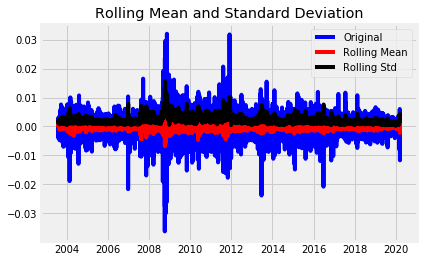

Results of dickey fuller test
Test Statistics                  -32.492352
p-value                            0.000000
No. of lags used                  23.000000
Number of observations used    25887.000000
critical value (1%)               -3.430603
critical value (5%)               -2.861652
critical value (10%)              -2.566829
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() 
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries)
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
df_close = df_aud['R_Close']
test_stationarity(df_close)

In [ ]:
df_aud[['Open','High','Low','Close','Volume ']] = scaler.fit_transform(df_aud[['Open','High','Low','Close','Volume ']].to_numpy())
df_aud.describe()

,Open,High,Low,Close,Volume
count,2.594000e+04,2.594000e+04,2.594000e+04,2.594000e+04,2.594000e+04
mean,-8.807741e-16,-5.893512e-16,6.669042e-17,-2.873911e-16,2.507865e-15
std,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00
min,-1.915662e+00,-1.864359e+00,-1.906929e+00,-1.915705e+00,-4.740305e-01
25%,-7.510094e-01,-7.533582e-01,-7.482241e-01,-7.511265e-01,-4.236941e-01
50%,-4.012810e-01,-4.017207e-01,-4.003991e-01,-4.013519e-01,-3.914353e-01
75%,7.976445e-01,8.002953e-01,7.948220e-01,7.975432e-01,-3.233942e-01
max,2.390532e+00,2.388279e+00,2.392792e+00,2.390276e+00,6.006833e+00


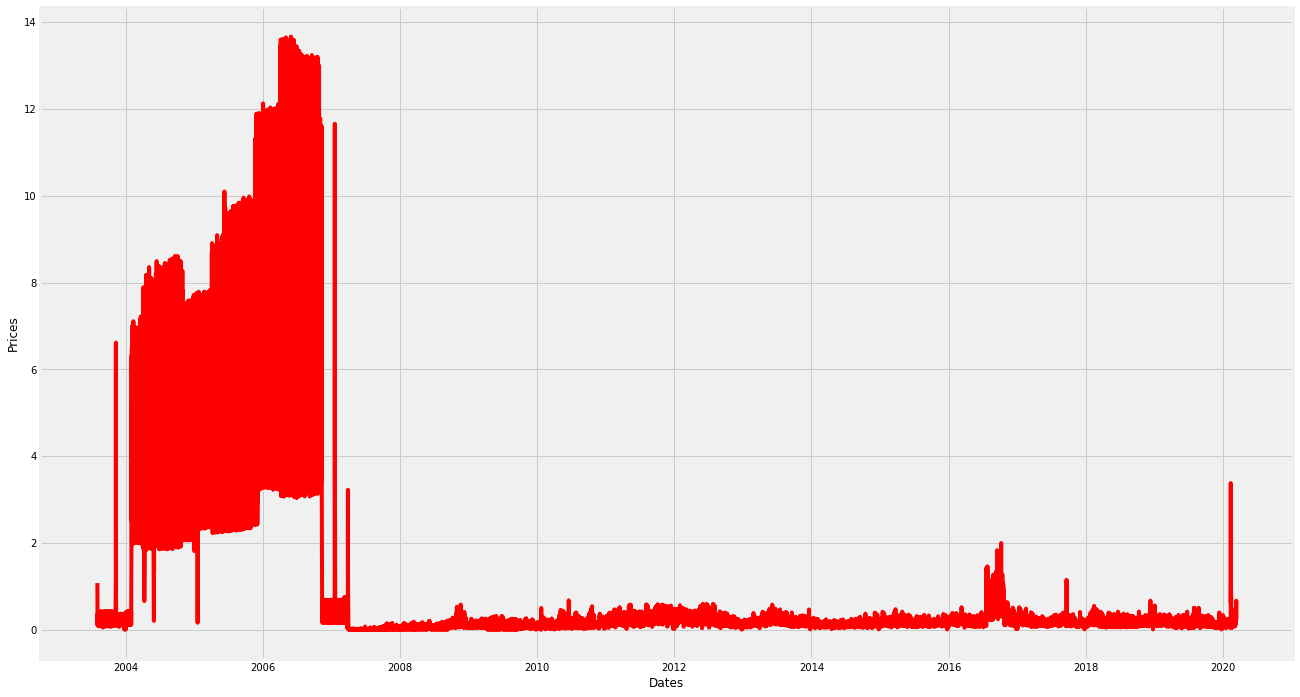

In [ ]:
plt.figure(figsize=(20,12))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.plot(df_aud['R_Close'],color='red')
#plt.plot(df_aud['Open'],color='blue')
#plt.plot(df_aud['High'],color='green')
#plt.plot(df_aud['Low'],color='black')
plt.plot(df_aud['Adj_Volume'],color='red')

plt.show()

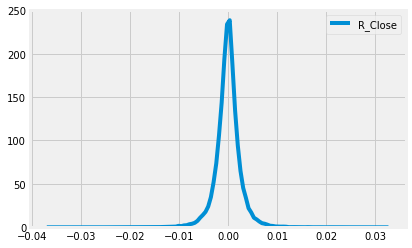

In [ ]:
dist = sns.kdeplot(df_aud['R_Close'])

<Figure size 432x288 with 0 Axes>

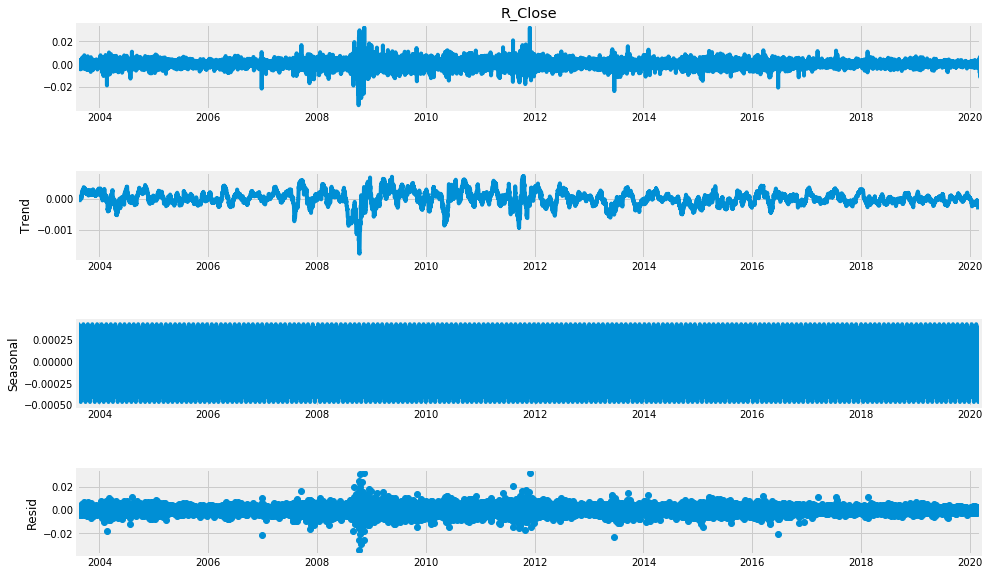

In [ ]:
result = seasonal_decompose(df_aud['R_Close'], model='additive',freq = 132)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [14]:
df_aud.info() # no null values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25807 entries, 2003-08-04 01:00:00 to 2020-03-12 21:00:00
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         25807 non-null  float64
 1   High         25807 non-null  float64
 2   Low          25807 non-null  float64
 3   Close        25807 non-null  float64
 4   Volume       25807 non-null  float64
 5   Volatility   25807 non-null  float64
 6   Adj_Volume   25807 non-null  float64
 7   R_Close      25807 non-null  float64
 8   R_Open       25807 non-null  float64
 9   R_High       25807 non-null  float64
 10  R_Low        25807 non-null  float64
 11  H-L          25807 non-null  float64
 12  O-L          25807 non-null  float64
 13  C-L          25807 non-null  float64
 14  H-O          25807 non-null  float64
 15  H-C          25807 non-null  float64
 16  O-C          25807 non-null  float64
 17  (C-O)/(H-L)  25807 non-null  float64
 18  (O-L)/(C)  

In [15]:
print(df_aud.describe())
print()
print(df_aud.median()-df_aud.mean())

               Open          High  ...     (O-L)/(C)     (O-H)/(C)
count  25807.000000  25807.000000  ...  25807.000000  25807.000000
mean       0.825890      0.827708  ...      0.002284      0.002234
std        0.117421      0.117519  ...      0.002562      0.002340
min        0.601550      0.609200  ...      0.000000      0.000000
25%        0.737875      0.739345  ...      0.000760      0.000774
50%        0.778570      0.780290  ...      0.001601      0.001609
75%        0.919805      0.921960  ...      0.002939      0.002946
max        1.106320      1.108100  ...      0.058815      0.051524

[8 rows x 20 columns]

Open              -0.047320
High              -0.047418
Low               -0.047158
Close             -0.047313
Volume        -90690.826864
Volatility        -0.000747
Adj_Volume        -0.829810
R_Close            0.000032
R_Open             0.000032
R_High            -0.000022
R_Low              0.000076
H-L               -0.000612
O-L               -0.000568
C-L      

In [41]:
from sklearn.model_selection import train_test_split

X = df_aud[['Open','Volatility','Adj_Volume','R_Close','R_Open','R_High','R_Low',
           'H-L','O-L','C-L','H-O','H-C','O-C','(C-O)/(H-L)','(O-L)/(C)','(O-H)/(C)']]
#y = df_aud[['High','Low','Close']]
y = df_aud['Close']

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state=42, shuffle = True)

if 0.7*X_train.shape[0] < 25807:
    train_split = 0.8
else:
    train_split = 0.7

X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, train_size=train_split, test_size=1-train_split, random_state=42, shuffle=True)

X_train = scaler.fit_transform(X_train)
X_cv = scaler.transform(X_cv)
X_test = scaler.transform(X_test)

print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(X_train.shape, y_train.shape, X_cv.shape, y_cv.shape, X_test.shape, y_test.shape))

Shape of x, y train/cv/test (16516, 16) (16516,) (4129, 16) (4129,) (5162, 16) (5162,)


In [47]:
def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

In [66]:
num_features=16
dim = int(np.sqrt(num_features))
#X_train = reshape_as_image(X_train, dim, dim)
#X_cv = reshape_as_image(X_cv, dim, dim)
#X_test = reshape_as_image(X_test, dim, dim)
# adding a 1-dim for channels (3)
X_train = np.stack((X_train,) * 1, axis=-1)
X_test = np.stack((X_test,) * 1, axis=-1)
X_cv = np.stack((X_cv,) * 1, axis=-1)


In [67]:
print("final shape of x, y train/test {} {} {} {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))


final shape of x, y train/test (16516, 4, 4, 3, 1) (16516,) (5162, 4, 4, 3, 1) (5162,)


In [49]:
params = {'batch_size': 80, 
          'conv2d_layers': {'conv2d_do_1': 0.25, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 
                            'conv2d_mp_1': 0, 'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 
                            'conv2d_do_2': 0.5, 'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3,
                            'conv2d_mp_2': 7, 'conv2d_strides_2': 1, 'kernel_regularizer_2': 0.0, 
                            'layers': 'two'},
          'dense_layers': {'dense_do_1': 0.0, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'},
          'epochs': 3000, 
          'lr': 0.001, 
          'optimizer': 'adam'}

In [68]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

def create_model_cnn(params):
    model = Sequential()

    print("Training with params {}".format(params))
    # (batch_size, timesteps, data_dim)
    # x_train, y_train = get_data_cnn(df, df.head(1).iloc[0]["timestamp"])[0:2]
    conv2d_layer1 = Conv2D(32,kernel_size=3,strides=1,activation="relu",input_shape=(16,16,1))
    model.add(conv2d_layer1)

    conv2d_layer2 = Conv2D(64,kernel_size=3,strides=1,activation="relu",input_shape=(16,16,1))
    model.add(conv2d_layer2)

    model.add(MaxPool2D(pool_size=2))

    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='softmax'))
    
    optimizer = optimizers.Adam(learning_rate=params["lr"], beta_1=0.9, beta_2=0.999, amsgrad=False)
        
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
  

In [69]:
def train_model(model, xtrain, ytrain,checkpoint,stoppoint,batch_size,epochs):    
    model.fit(xtrain, ytrain, batch_size = batch_size, epochs = epochs, validation_split= 0.3 , 
              callbacks=[checkpoint, stoppoint],verbose=1)
    return model.history

In [70]:
def plotHistory(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [53]:
def plotMetrics(threshold, X_test_scaled, y_test):
    model = load_model('model.h5')
    y_pred = model.predict(X_test_scaled)
    y_pred = (y_pred > threshold)
    print(boldTextStart,'Accuracy:',boldTextEnd)
    accuracy_model = accuracy_score(y_test, y_pred, normalize=True)*100
    print(accuracy_model,' %')
    print(boldTextStart,'Confusion Matrix:',boldTextEnd)
    print(confusion_matrix(y_test,y_pred))
    print(boldTextStart,'Classification Report:',boldTextEnd)
    print(classification_report(y_test,y_pred))
    auc = roc_auc_score(y_test,y_pred)
    print(boldTextStart,'AUC Score: ',boldTextEnd, auc)

In [71]:
m = create_model_cnn(params)
m.summary()
history = m.fit(X_train, y_train, epochs=params['epochs'], verbose=0,
                            batch_size=80, shuffle=True,
                            #validation_split=0.3,
                            #validation_data=(X_cv, y_cv),
                            #callbacks=[mcp, rlp, es]
                            #, sample_weight=sample_weights
                )
y_pred = m.predict(X_test)
print(confusion_matrix(y_test,y_pred))
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)
#print('Plot feature importances...')
#plot_importance(m, max_num_features=10)
#auc = roc_auc_score(y_test,y_pred)
#print('AUC: ', auc)

Training with params {'batch_size': 80, 'conv2d_layers': {'conv2d_do_1': 0.25, 'conv2d_filters_1': 32, 'conv2d_kernel_size_1': 3, 'conv2d_mp_1': 0, 'conv2d_strides_1': 1, 'kernel_regularizer_1': 0.0, 'conv2d_do_2': 0.5, 'conv2d_filters_2': 64, 'conv2d_kernel_size_2': 3, 'conv2d_mp_2': 7, 'conv2d_strides_2': 1, 'kernel_regularizer_2': 0.0, 'layers': 'two'}, 'dense_layers': {'dense_do_1': 0.0, 'dense_nodes_1': 128, 'kernel_regularizer_1': 0.0, 'layers': 'one'}, 'epochs': 3000, 'lr': 0.001, 'optimizer': 'adam'}
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 64)          0         
_

ValueError: ignored